## visualize transformed images

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tqdm.auto as tqdm
import os
import wandb
from wandb.sdk.wandb_run import Run
import pdb
from models import MeanAbsoluteError, ReverseCrossEntropyLoss, SymmetricCrossEntropyLoss, \
    GeneralizedCrossEntropyLoss, CrossEntropyDistillationLoss
from models import KLDivDistillationLoss, L1DistillationLoss, SmoothL1DistillationLoss, Normalize2D
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision import transforms
import torchvision.transforms.v2 as transforms_v2
import numpy as np
import datasets
from trainer import Trainer

Files already downloaded and verified


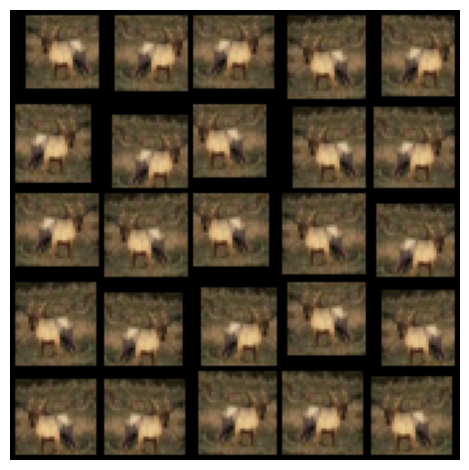

In [16]:
import torchshow
import torchvision.utils as vutils

train_dataset, test_dataset = datasets.get_dataset(dataset='cifar10', download=True)
train_dataset.transform = Trainer.get_transform('randomcrop', train_dataset)
# train_dataset.transform2 = Trainer.get_transform('autoaugment', train_dataset)


idx = 3

# tensor = torch.cat([
#     vutils.make_grid([train_dataset[idx]['image'] for _ in range(25)], nrow=5),
#     vutils.make_grid([train_dataset[idx]['image2'] for _ in range(25)], nrow=5),
# ], dim=2)


tensor = vutils.make_grid([train_dataset[idx]['image'] for _ in range(25)], nrow=5)
torchshow.show(tensor)

In [19]:
from concurrent.futures import ProcessPoolExecutor
import os
from pathlib import Path
import tqdm.auto as tqdm


train_dataset, test_dataset = datasets.get_dataset(dataset='cifar10', download=True)

root = Path('/dev/shm/temp/cifar10-vis/')
root.mkdir(parents=True, exist_ok=True)

labels = []
paths = []
tranform_ops = []
max_len = 1000

for teacher_aug in ['none', 'randomcrop', 'gaussianblur', 'rotate', 'colorjitter']:
    train_dataset.transform = Trainer.get_transform(teacher_aug, train_dataset)
    transform = Trainer.get_transform(teacher_aug, train_dataset)

    for idx in tqdm.trange(max_len):
        path = f'images/{idx}-{teacher_aug}.jpg'
        paths.append(path)
        labels.append(train_dataset[idx]['target'])
        tranform_ops.append(teacher_aug)
        tensor = vutils.make_grid([train_dataset[idx]['image'] for _ in range(9)], nrow=3)
        torchshow.save(tensor, os.path.join(root, path)) # save image to disk


import pandas as pd
df = pd.DataFrame({'path': paths, 'label': [train_dataset.classes[x] for x in labels], 'transform_op': tranform_ops})
df.to_csv(os.path.join(root, 'labels.csv'), index=False) # save labels to disk
df

Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

import glob
import fiftyone as fo
import os
import pandas as pd

root = '/dev/shm/temp/cifar10-vis/'
df = pd.read_csv(os.path.join(root, 'labels.csv'))

# Create samples for your data
samples = []
for i, x in df.iterrows():
    sample = fo.Sample(filepath=os.path.join(root, x['path']))
    sample["label"] = fo.Classification(label=x['label'])
    sample["transform_op"] = fo.Classification(label=x['transform_op'])
    samples.append(sample)

# Create dataset
dataset = fo.Dataset()
dataset.add_samples(samples)

 100% |███████████████| 5000/5000 [2.3s elapsed, 0s remaining, 2.2K samples/s]      


['64be8fe2825f3d7d4d001b3e',
 '64be8fe2825f3d7d4d001b3f',
 '64be8fe2825f3d7d4d001b40',
 '64be8fe2825f3d7d4d001b41',
 '64be8fe2825f3d7d4d001b42',
 '64be8fe2825f3d7d4d001b43',
 '64be8fe2825f3d7d4d001b44',
 '64be8fe2825f3d7d4d001b45',
 '64be8fe2825f3d7d4d001b46',
 '64be8fe2825f3d7d4d001b47',
 '64be8fe2825f3d7d4d001b48',
 '64be8fe2825f3d7d4d001b49',
 '64be8fe2825f3d7d4d001b4a',
 '64be8fe2825f3d7d4d001b4b',
 '64be8fe2825f3d7d4d001b4c',
 '64be8fe3825f3d7d4d001b4d',
 '64be8fe3825f3d7d4d001b4e',
 '64be8fe3825f3d7d4d001b4f',
 '64be8fe3825f3d7d4d001b50',
 '64be8fe3825f3d7d4d001b51',
 '64be8fe3825f3d7d4d001b52',
 '64be8fe3825f3d7d4d001b53',
 '64be8fe3825f3d7d4d001b54',
 '64be8fe3825f3d7d4d001b55',
 '64be8fe3825f3d7d4d001b56',
 '64be8fe3825f3d7d4d001b57',
 '64be8fe3825f3d7d4d001b58',
 '64be8fe3825f3d7d4d001b59',
 '64be8fe3825f3d7d4d001b5a',
 '64be8fe3825f3d7d4d001b5b',
 '64be8fe3825f3d7d4d001b5c',
 '64be8fe3825f3d7d4d001b5d',
 '64be8fe3825f3d7d4d001b5e',
 '64be8fe3825f3d7d4d001b5f',
 '64be8fe3825f

In [2]:
session = fo.launch_app(dataset, auto=False, address='0.0.0.0', port=5152)

Session launched. Run `session.show()` to open the App in a cell output.


In [3]:
session.close()

# Visualize softmax

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tqdm.auto as tqdm
import os
import wandb
from wandb.sdk.wandb_run import Run
import pdb
from models import MeanAbsoluteError, ReverseCrossEntropyLoss, SymmetricCrossEntropyLoss, \
    GeneralizedCrossEntropyLoss, CrossEntropyDistillationLoss
from models import KLDivDistillationLoss, L1DistillationLoss, SmoothL1DistillationLoss, Normalize2D
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision import transforms
import torchvision.transforms.v2 as transforms_v2
import numpy as np
import datasets
from trainer import Trainer

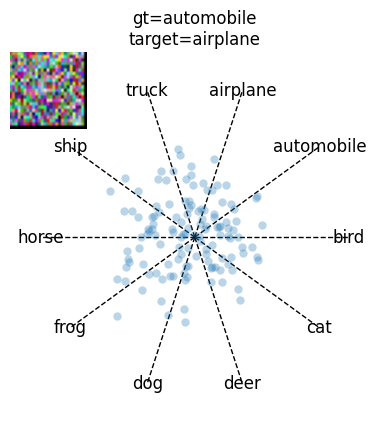

In [22]:
import numpy as np
import torch
import numpy.random as nprn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from scipy.special import softmax


def get_projection_matrix(k):
    theta = (2*np.pi/k) * (np.arange(k) + 0.5)
    return np.stack([np.sin(theta), np.cos(theta)], axis=0)


def draw_equiradial_projection_plot(
        ax: plt.Axes,
        class_names: list,
        logits: torch.Tensor,
        image: torch.Tensor = None,
        title: str = None,
    ):
    num_classes = logits.shape[-1]
    T = get_projection_matrix(num_classes)

    # Plot the octagon
    vertices = T @ np.eye(num_classes)
    vertices = np.hstack([vertices, vertices[:, 0:1]])
    for i, vertex in enumerate(vertices[:,:-1].T):
        ax.text(vertex[0], vertex[1], class_names[i], ha='center', va='center', fontsize=12)
        ax.plot([0, vertex[0]], [0, vertex[1]], 'k--', linewidth=1)

    # Plot the points
    x = logits.div(1).softmax(-1).numpy()
    points = T @ x.T
    ax.scatter(points[0], points[1], linewidth=0, alpha=0.3, zorder=10)
    # ax.scatter([pointpred[0]], [pointpred[1]], color='red', alpha = 0.3, s=50, linewidth=0, zorder=12)

    # plot image
    if image is not None:
        ax.imshow(image, extent=[-1.3, -0.7, 0.7, 1.4], origin='upper')
        # plt.figimage(image)

    if title is not None:
        ax.set_title(title)

    # Set the axis limits
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    ax.set_axis_off()


class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots()

image = torch.randint(255, (32,32,3)).to(torch.uint8)
image[0,:,:] = 0
image[:,0,:] = 0
image[:,-1,:] = 0
image[-1,:,:] = 0

draw_equiradial_projection_plot(ax, class_names, torch.randn((128,10)), image=image, title=f'gt={class_names[1]}\ntarget={class_names[0]}')


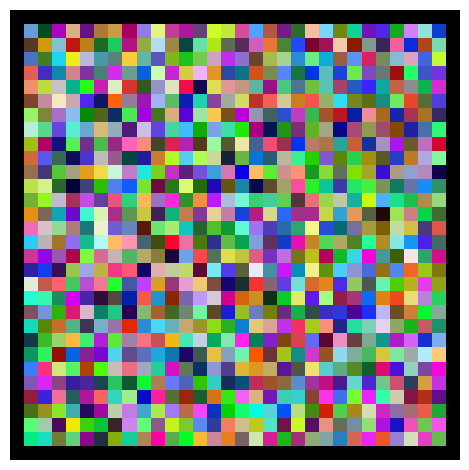

In [8]:
import torchshow
image = torch.randint(255, (32,32,3)).to(torch.uint8)
image[0,:,:] = 0
image[:,0,:] = 0
image[:,-1,:] = 0
image[-1,:,:] = 0
torchshow.show(image)

In [24]:
import os
from pathlib import Path
import tqdm.auto as tqdm
from collections import defaultdict
import datasets
from trainer import Trainer
import torch
import matplotlib.pyplot as plt


train_dataset, test_dataset = datasets.get_dataset(dataset='noisy_cifar10', download=True)

root = Path('/dev/shm/temp/cifar10-vis-equir-59/')
root.mkdir(parents=True, exist_ok=True)

result = []
max_len = 200
class_names = train_dataset.classes #['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


import models
model = models.get_model(architecture='resnet18', num_classes=10)
model = torch.compile(model)
trainer = Trainer(model, device='cuda:0')
normalize = Trainer.get_normalization(train_dataset)


import wandb

def load_checkpoint(name="model_199.pth", wandb_id=None):
    checkpoint = wandb.restore(name, run_path=f"hyounguk-shon/noisy-label/{wandb_id}", replace=True, root='./temp')
    trainer.model.load_state_dict(torch.load(checkpoint.name, map_location="cuda"))
    print(f"Loaded checkpoint: {checkpoint.name}")




student_aug = ['none', 'randomcrop', 'rotate', 'gaussianblur', 'colorjitter']
teacher_aug = ['none', 'randomcrop', 'rotate', 'gaussianblur', 'colorjitter']
data = [
    ['v5zhfms2', 'zvsdvgvk', '1wipxqcw', 'anbwxfi7', '86xaamhc'],
    ['76d6ia30', '76d6ia30', 'p1l5cwbx', 'gvafdtem', 'zjl2ymv6'],
    ['3z59sdls', 'jhpcobg8', 'zk3qcx7f', '7g3059gr', 's0ydabr1'],
    ['h9biom9b', 'ns5zw2h6', 'vobgwzil', 'vs4ly0xa', 'kt6y1nij'],
    ['mb4pwiw3', 'pzqcfyay', 'qbtj6cow', 'p2pnv9e3', 'f50664g4']
]
run_ids = pd.DataFrame(data, index=student_aug, columns=teacher_aug)


for teacher_aug in ['none', 'randomcrop', 'gaussianblur', 'rotate', 'colorjitter']:
    for student_aug in ['none', 'randomcrop', 'gaussianblur', 'rotate', 'colorjitter']:

        train_dataset.transform = lambda x: torch.tensor(np.array(x)).permute(2,0,1)
        transform = Trainer.get_transform(teacher_aug, train_dataset)

        load_checkpoint(name="model_59.pth", wandb_id=run_ids.loc[student_aug, teacher_aug])

        for idx in tqdm.trange(max_len):
            image = train_dataset[idx]['image']
            input = torch.stack([transform(image) for _ in range(20)], dim=0)
            input = normalize(input)
            logits = trainer.predict_batch(input).cpu()
            path = Path(f'images/{idx}-{student_aug}-{teacher_aug}.jpg')
            path.mkdir(parents=True, exist_ok=True)


            target = train_dataset[idx]['target']
            target_gt = train_dataset[idx]['target_gt']

            result.append(
                {
                    'paths': path,
                    'targets': train_dataset.classes[target],
                    'targets_gt': train_dataset.classes[target_gt],
                    'augmentation_b': student_aug,
                    'augmentation_a': teacher_aug,
                }
            )

            fig, ax = plt.subplots()
            draw_equiradial_projection_plot(ax, class_names, logits, image=image.permute(1,2,0), title=f'target={train_dataset.classes[target]}\ngt={train_dataset.classes[target_gt]}')

            plt.savefig(os.path.join(root, path), bbox_inches='tight')
            plt.close()


import pandas as pd
df = pd.DataFrame(result)
df.to_csv(os.path.join(root, 'labels.csv'), index=False) # save labels to disk
df

Files already downloaded and verified


In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

import glob
import fiftyone as fo
import os
import pandas as pd

root = '/dev/shm/temp/cifar10-vis-equir-199/'
df = pd.read_csv(os.path.join(root, 'labels.csv'))

# Create samples for your data
samples = []
for i, x in df.iterrows():
    sample = fo.Sample(filepath=os.path.join(root, x['paths']))
    for k, v in x.items():
        sample[k] = fo.Classification(label=v)
    samples.append(sample)

# Create dataset
dataset = fo.Dataset()
dataset.add_samples(samples)

# launch the App
session = fo.launch_app(dataset, auto=False, address='0.0.0.0', port=5152)

 100% |███████████████| 5000/5000 [4.3s elapsed, 0s remaining, 1.2K samples/s]       
Session launched. Run `session.show()` to open the App in a cell output.


In [2]:
session.close()